In [1]:
from collections import Counter
from wordcloud import WordCloud

In [2]:
# Utils
from src.plot_function import *
from src.ml_function import *
from src.nlp_function import *

# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)

In [3]:
import re

# import nltk
# nltk.download('stopwords')
# nltk.download('rslp')

from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

In [5]:
import lightgbm as lgb

In [6]:
# Reading all the files
raw_path = 'data/archive/'
olist_customer = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
olist_geolocation = pd.read_csv(raw_path + 'olist_geolocation_dataset.csv')
olist_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
olist_order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv(raw_path + 'olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv(raw_path + 'olist_order_reviews_dataset.csv')
olist_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
olist_sellers = pd.read_csv(raw_path + 'olist_sellers_dataset.csv')

In [7]:
# Collections for each dataset
datasets = [olist_customer, olist_geolocation, olist_orders, olist_order_items, olist_order_payments,
            olist_order_reviews, olist_products, olist_sellers]
names = ['olist_customer', 'olist_geolocation', 'olist_orders', 'olist_order_items', 'olist_order_payments',
         'olist_order_reviews', 'olist_products', 'olist_sellers']

In [8]:
# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info

,dataset,n_rows,n_cols,null_amount,qty_null_columns,null_columns
0,olist_customer,99441,5,0,0,
1,olist_geolocation,1000163,5,0,0,
2,olist_orders,99441,8,4908,3,"order_approved_at, order_delivered_carrier_dat..."
3,olist_order_items,112650,7,0,0,
4,olist_order_payments,103886,5,0,0,
5,olist_order_reviews,99224,7,145903,2,"review_comment_title, review_comment_message"
6,olist_products,32951,9,2448,8,"product_category_name, product_name_lenght, pr..."
7,olist_sellers,3095,4,0,0,


---

# NLP

In [9]:
df_comments = olist_order_reviews.loc[:, ['review_score', 'review_comment_message']]
df_comments = df_comments.dropna(subset=['review_comment_message'])
df_comments = df_comments.reset_index(drop=True)

In [10]:
df_comments.columns = ['score', 'comment']
df_comments

,score,comment
0,5,Recebi bem antes do prazo estipulado.
1,5,Parabéns lojas lannister adorei comprar pela I...
2,4,aparelho eficiente. no site a marca do aparelh...
3,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,5,"Vendedor confiável, produto ok e entrega antes..."
...,...,...
40972,4,para este produto recebi de acordo com a compr...
40973,5,Entregou dentro do prazo. O produto chegou em ...
40974,3,"O produto não foi enviado com NF, não existe v..."
40975,5,"Excelente mochila, entrega super rápida. Super..."


In [11]:
sentiment_label = {
    1: 'negative',
    2: 'negative',
    3: 'negative',
    4: 'positive',
    5: 'positive'
}
df_comments['sentiment_label'] = df_comments['score'].map(sentiment_label)

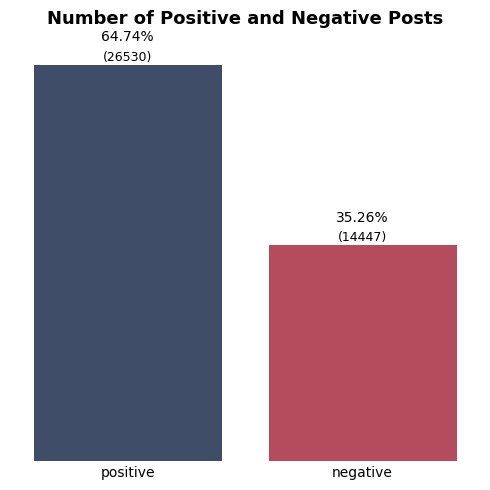

In [12]:
hue='sentiment_label'

visualizer = DataVisualizer(df_comments, figsize=(5, 5), title = f'Number of Positive and Negative Posts')
visualizer.plot_categorical_distribution(hue=hue, palette = ['#394b70', '#c53b53'])

# Pipeline Text

In [13]:
pt_stopwords =stopwords.words('portuguese')

vectorizer = TfidfVectorizer(max_features=300, min_df=6, max_df=0.7, stop_words=pt_stopwords)

In [ ]:
regex_cleaner = {
    'clean_breaklines': RegexCleaner.clean_breaklines,
    'clean_links': RegexCleaner.clean_links,
    'clean_dates': RegexCleaner.clean_dates,
    'clean_currency': RegexCleaner.clean_currency,
    'clean_numbers': RegexCleaner.clean_numbers,
    'clean_negations': RegexCleaner.clean_negations,
    'clean_special_characters': RegexCleaner.clean_special_characters,
    'clean_whitespace': RegexCleaner.clean_whitespace,
    'clean_emojis' : RegexCleaner.clean_emojis,
    'reduce_repeated_chars' : RegexCleaner.reduce_repeated_chars,
    'remove_accents' : RegexCleaner.remove_accents,
    'replace_slang' : RegexCleaner.replace_slang,
}

In [ ]:
text_pipeline = Pipeline([
    ('RegexPreprocessor', RegexPreprocessor(regex_cleaner)),
    ('StopwordRemover', StopwordRemover(pt_stopwords)),
    ('StemmerTransformer', StemmerTransformer(RSLPStemmer())),
    ('TextVectorizer', TextVectorizer(vectorizer))
])

In [16]:
review_idx = olist_order_reviews['review_comment_message'].dropna().index
review_score = olist_order_reviews['review_score'][review_idx].map(sentiment_label)

y_labels = review_score.apply(lambda x: 1 if x == 'positive' else 0).values

In [17]:
X_reviews = list(olist_order_reviews['review_comment_message'][review_idx].values)

X_processed = text_pipeline.fit_transform(X_reviews)

# fitted_vectorizer = text_pipeline.named_steps['text_features'].vectorizer
# feature_names = fitted_vectorizer.get_feature_names_out()

In [18]:
# X = pd.DataFrame(X_processed, columns=feature_names)
# y = pd.DataFrame(y_labels, columns=['review_score'])

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_labels, random_state=42)

### Boost Hypterparametres

In [19]:
# boost = ClassificationHyperTuner(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, model_name='lgb')
# best_params_LGBMClassifier, best_value_LGBMClassifier = boost.run_optimization()

In [20]:
best_params_LGBMClassifier = {'learning_rate': 0.061031154282830485,
                              'n_estimators': 1120,
                              'num_leaves': 62,
                              'max_depth': 5,
                              'min_data_in_leaf': 17,
                              'subsample': 0.8225216401895699,
                              'colsample_bytree': 0.8089785493695208,
                              'reg_alpha': 0.46371610922389833,
                              'reg_lambda': 0.7444401543058722,
                              'max_bin': 226,
                              "verbose": -1}

model_lgb = lgb.LGBMClassifier(**best_params_LGBMClassifier)

train_lgb = TrainingValidation(model=model_lgb)

/home/rvanguita/github/Brazilian_E-Commerce/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/rvanguita/github/Brazilian_E-Commerce/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


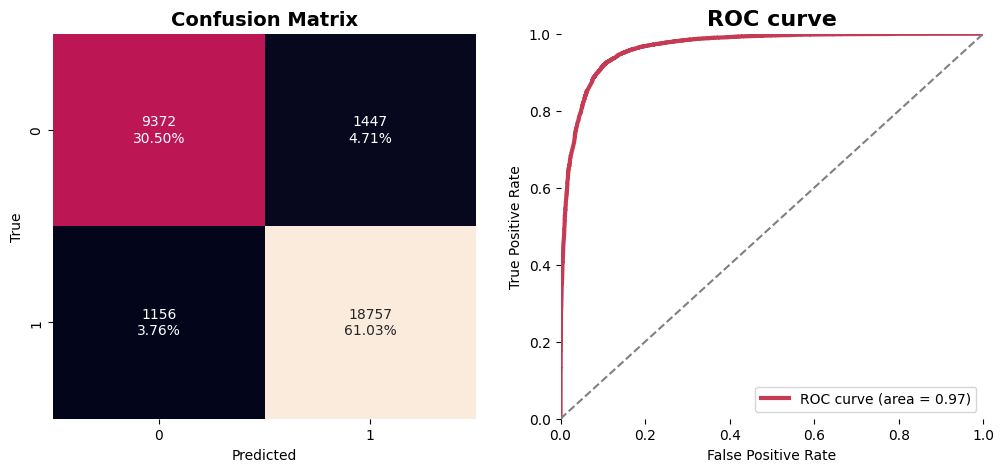

<Figure size 640x480 with 0 Axes>

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Matthews Corrcoef,Cohen Kappa,Log Loss
0,91.53,91.49,91.53,91.5,96.57,0.81,0.81,22.88


In [21]:
normal_score_lgb = train_lgb.normal(X=X_train, y=y_train)
normal_score_lgb

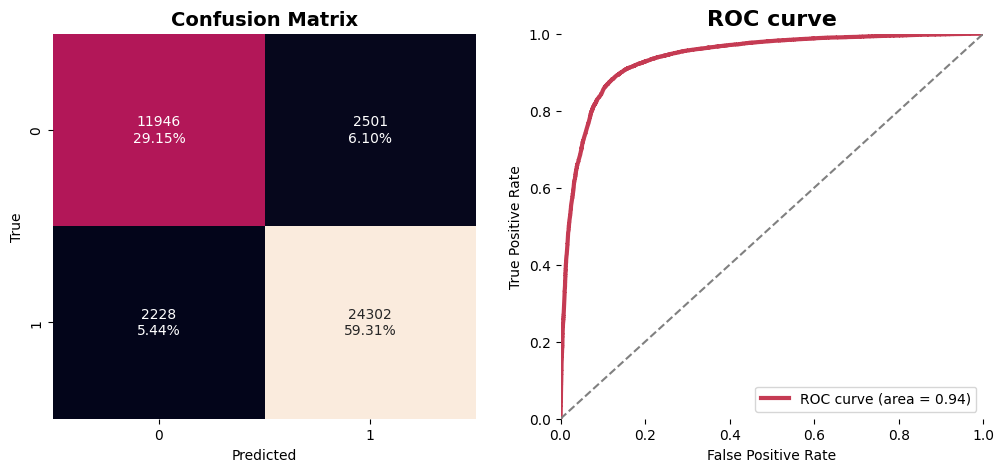

<Figure size 640x480 with 0 Axes>

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Matthews Corrcoef,Cohen Kappa,Log Loss
0,88.46,88.42,88.46,88.43,93.95,0.75,0.75,29.49


In [22]:
cross_validation_scores_lgb= train_lgb.cross(X=X_processed, y=y_labels, n_splits= 5)
cross_validation_scores_lgb 

In [23]:

combined_df = pd.concat([normal_score_lgb,
                         cross_validation_scores_lgb,
                         ], ignore_index=True)
index_names = ['normal_lgb', 
               'cross_lgb', 
]


combined_df['scores'] = index_names
combined_df = combined_df.set_index('scores')

combined_df.sort_values(by='Log Loss')

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Matthews Corrcoef,Cohen Kappa,Log Loss
scores,,,,,,,,
normal_lgb,91.53,91.49,91.53,91.50,96.57,0.81,0.81,22.88
cross_lgb,88.46,88.42,88.46,88.43,93.95,0.75,0.75,29.49


In [24]:
# Define the preprocessing pipeline for text input
trained_pipeline = Pipeline([
    ('regex', RegexPreprocessor(regex_cleaner)),
    ('stopwords', StopwordRemover(pt_stopwords)),
    ('stemming', StemmerTransformer(RSLPStemmer())),
])

# Accessing the vectorizer from the 'text_features' step of the pipeline
trained_vectorizer = text_pipeline.named_steps['text_features'].vectorizer

trained_model = model_lgb

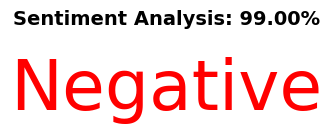

In [25]:
comment = 'Péssimo produto! Não compro nessa loja, a entrega atrasou e custou muito dinheiro!'

plot_sentiment_prediction(
    input_text=comment, 
    text_pipeline=trained_pipeline, 
    tfidf_vectorizer=trained_vectorizer, 
    classifier_model=trained_model)

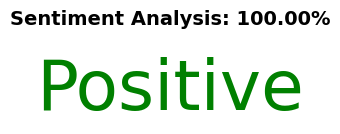

In [26]:
comment = 'Adorei e realmente cumpriu as expectativas. Comprei por um valor barato. Maravilhoso'

plot_sentiment_prediction(
    input_text=comment, 
    text_pipeline=trained_pipeline, 
    tfidf_vectorizer=trained_vectorizer, 
    classifier_model=trained_model)

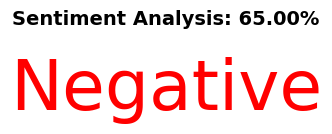

In [27]:
comment = 'Não sei gostei do produto. O custo foi barato mas veio com defeito. Se der sorte, vale a pena'

plot_sentiment_prediction(
    input_text=comment, 
    text_pipeline=trained_pipeline, 
    tfidf_vectorizer=trained_vectorizer, 
    classifier_model=trained_model)

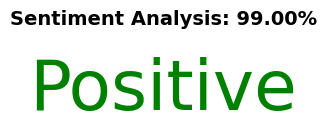

In [28]:
comment = 'Vendedor confiável, produto ok e entrega antes do prazo.'

plot_sentiment_prediction(
    input_text=comment, 
    text_pipeline=trained_pipeline, 
    tfidf_vectorizer=trained_vectorizer, 
    classifier_model=trained_model)

In [29]:
df_reviews = list(olist_order_reviews['review_comment_message'][review_idx].values)

df_processed = trained_pipeline.fit_transform(df_reviews)

fitted_vectorizer = text_pipeline.named_steps['text_features'].vectorizer
feature_names = fitted_vectorizer.get_feature_names_out()
df_complete = pd.DataFrame(df_processed, columns=['comment'])
df_complete['sentiment_label'] = df_comments['score'].map(sentiment_label)

In [30]:
# remove_accents
pos_comments = list(df_complete.query('sentiment_label == "positive"')['comment'].values)
positive_words = ' '.join(pos_comments).split(' ')

positive_dict = Counter(positive_words)

In [31]:
neg_comments = list(df_complete.query('sentiment_label == "negative"')['comment'].values)
negative_words = ' '.join(neg_comments).split(' ')

negative_dict = Counter(negative_words)

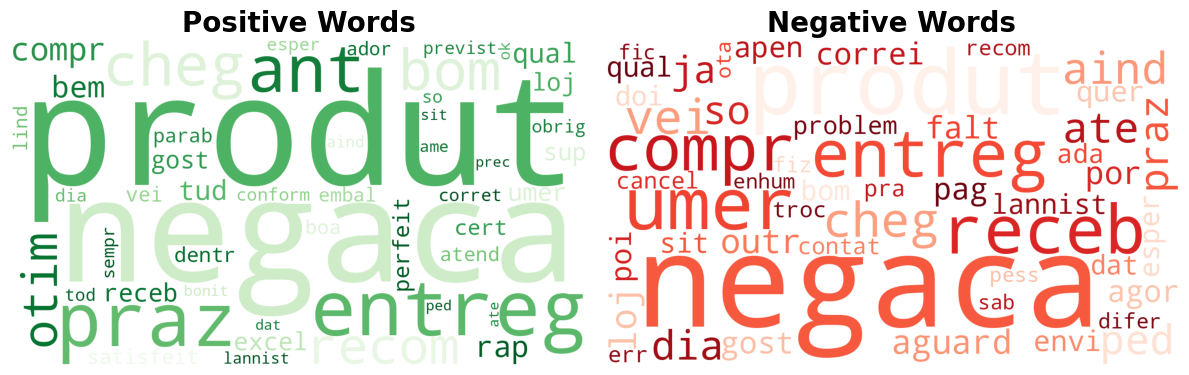

In [32]:
def generate_wordcloud(freq_dict, colormap='Greens'):
    return WordCloud(
        width=1280,
        height=720,
        collocations=False,
        random_state=42,
        colormap=colormap,
        background_color='white',
        max_words=50
    ).generate_from_frequencies(freq_dict)

# Gerar as WordClouds
positive_wc = generate_wordcloud(positive_dict, colormap='Greens')
negative_wc = generate_wordcloud(negative_dict, colormap='Reds')

# Visualizar
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

axs[0].imshow(positive_wc)
axs[0].axis('off')
axs[0].set_title('Positive Words', fontsize=20, fontweight='bold')

axs[1].imshow(negative_wc)
axs[1].axis('off')
axs[1].set_title('Negative Words', fontsize=20, fontweight='bold')

plt.tight_layout()
plt.show()

In [38]:
def plot_top_words(freq_dict, ax, color='green', title='Top Words', top_n=20):
    """
    Plots a horizontal bar chart of the most frequent words on a given axis.
    
    Parameters:
    - freq_dict: dict[str, int/float]
        Dictionary of words and their frequencies.
    - ax: matplotlib.axes._subplots.AxesSubplot
        The axis on which to draw the plot.
    - color: str
        Bar color.
    - title: str
        Plot title.
    - top_n: int
        Number of top words to display.
    """
    sorted_items = sorted(freq_dict.items(), key=lambda item: item[1], reverse=True)[:top_n]
    words, freqs = zip(*sorted_items)

    ax.barh(words[::-1], freqs[::-1], color=color)
    ax.set_xlabel('Frequency')
    ax.set_title(title, fontsize=16, fontweight='bold')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


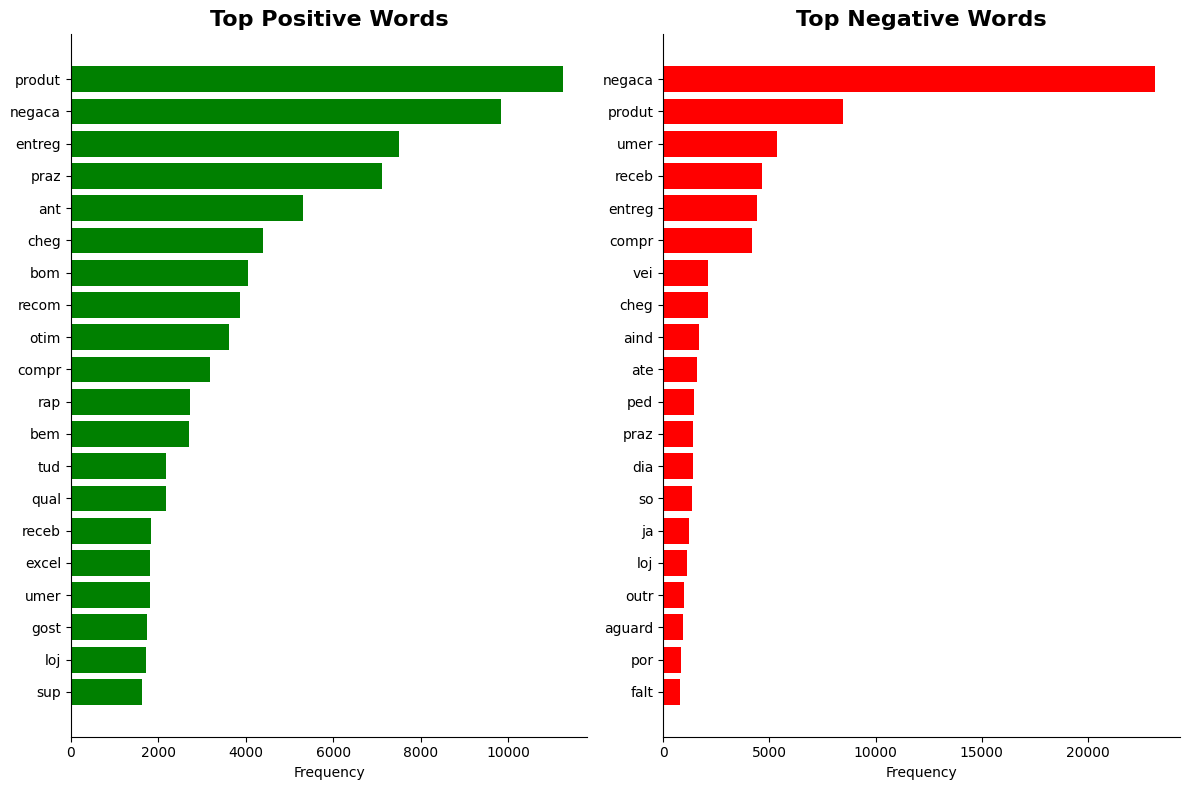

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))  # 1 linha, 2 colunas

plot_top_words(positive_dict, ax=axs[0], color='green', title='Top Positive Words')
plot_top_words(negative_dict, ax=axs[1], color='red', title='Top Negative Words')

plt.tight_layout()
plt.show()